<a href="https://colab.research.google.com/github/jemillett/DS_Course0_Week1_Module2_DataTypes/blob/main/Summative_Lab_DataVine_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install rdatasets


In [39]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from rdatasets import data

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import load_wine
from rdatasets import data
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Load CSV Files
wine_df = pd.read_csv('wine_data.csv')
chickwts_df = pd.read_csv('chickwts_data.csv')
arrests_df = pd.read_csv('arrests_data.csv')

print('RAW DATA SHAPES')
print("Wine:", wine_df.shape)
print("Chickwts:", chickwts_df.shape)
print("USArrests:", arrests_df.shape)

# Inspect for Missing Values
print('\nMISSING VALUES')
print("Wine:\n", wine_df.isnull().sum())
print("Chickwts:\n", chickwts_df.isnull().sum())
print("USArrests:\n", arrests_df.isnull().sum())

# Standardiz Numerical Features

# Wine dataset: all numeric featues except target
wine_featues = wine_df.drop('target', axis=1)
wine_scaler = StandardScaler()
wine_scaled = wine_scaler.fit_transform(wine_featues)
wine_scaled_df = pd.DataFrame(wine_scaled, columns=wine_featues.columns)
wine_scaled_df['target'] = wine_df['target']

# Chicwts dataset: standardize weight only
chickwts_scaler = StandardScaler()
chickwts_df['weight_scaled'] = chickwts_scaler.fit_transform(
    chickwts_df[['weight']]
    )

# USArrsts dataset: all coumns are numeric
arrests_scaler = StandardScaler()
arrests_features = arrests_df.drop('Unnamed: 0', axis=1)
arrests_scaled = arrests_scaler.fit_transform(arrests_features)
arrests_scaled_df = pd.DataFrame(arrests_scaled, columns=arrests_features.columns)

#Summary Outputs
print("\nDataset Summaries")
print("Wine Summary:\n", wine_scaled_df.describe())
print("Chickwts Summary:\n", chickwts_df.describe())
print("USArrests Summary:\n", arrests_scaled_df.describe())

RAW DATA SHAPES
Wine: (178, 14)
Chickwts: (100, 16)
USArrests: (50, 5)

MISSING VALUES
Wine:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64
Chickwts:
 feed_name              0
proteinContent         0
fatContent             0
fiberContent           0
calciumContent         0
phosphorusContent      0
moistureContent        0
ashContent             0
metabolizableEnergy    0
lysineContent          0
methionineContent      0
particleSize           0
density                0
price                  0
shelfLife              0
weight                 0
dtype:

In [12]:
# Clean up USArrests: drop non-informative index column
# The 'Unnamed: 0' column contains state names, which are not numeric and should not be scaled.
# Ensure 'Unnamed: 0' is dropped before scaling.

# Create a temporary DataFrame for scaling without the 'Unnamed: 0' column.
arrests_numeric_features = arrests_df.drop('Unnamed: 0', axis=1)

arrest_scaler = StandardScaler()
arrests_scaled_data = arrest_scaler.fit_transform(arrests_numeric_features)
arrests_scaled_df = pd.DataFrame(arrests_scaled_data, columns=arrests_numeric_features.columns)

print("USArrests cleaned shape:", arrests_numeric_features.shape)
print("\nUSArrests (cleaned and scaled) summary:\n", arrests_scaled_df.describe())

USArrests cleaned shape: (50, 4)

USArrests (cleaned and scaled) summary:
              Murder       Assault      UrbanPop          Rape
count  5.000000e+01  5.000000e+01  5.000000e+01  5.000000e+01
mean  -7.105427e-17  1.387779e-16 -4.396483e-16  8.593126e-16
std    1.010153e+00  1.010153e+00  1.010153e+00  1.010153e+00
min   -1.620693e+00 -1.524362e+00 -2.340661e+00 -1.502548e+00
25%   -8.611383e-01 -7.486054e-01 -7.704502e-01 -6.640245e-01
50%   -1.247758e-01 -1.425453e-01  3.210209e-02 -1.220847e-01
75%    8.029251e-01  9.483628e-01  8.521012e-01  5.330962e-01
max    2.229265e+00  2.015028e+00  1.776781e+00  2.671197e+00


Training size: (142, 13)
Testing size: (36, 13)

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 13}
Best CV Accuracy: 0.9719
Total Variance Explained by PCA: 0.962

Test Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



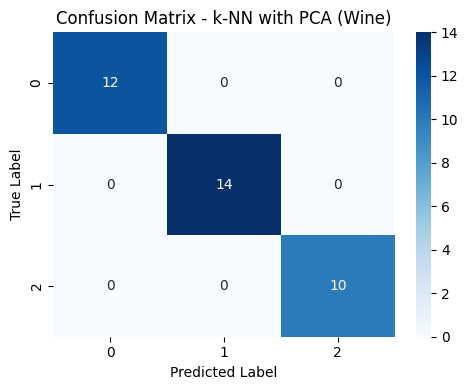

In [18]:
# Feature/Target
X = wine_df.drop('target', axis=1)
y = wine_df['target']

# If target is categorical strings, covert to numeric codes
if y.dtype == 'object':
    y, class_names = pd.factorize(y)
else:
  class_names = np.unique(y)

# Train/Test Split (stratified, repoducible)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=y # perserve class proportions
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)

# Pipeline: StandardScaleer -> PCA (95% var) -> k-NN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)), # retain 95% of variance
    ('knn', KNeighborsClassifier())
])

# GridSearchCV: tune k and distance metric
param_grid = {
    'knn__n_neighbors': list(range(3, 21, 2)), #odd k from 3 to 19
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# PCA details
pca = best_model.named_steps['pca']
n_components = pca.n_components_
explained_var = pca.explained_variance_ratio_.sum()
print(f"Total Variance Explained by PCA: {explained_var:.3f}")

# Evaluate on Test Set
y_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.4f}".format(test_acc))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm, annot=True,
    fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - k-NN with PCA (Wine)')
plt.tight_layout
plt.show()



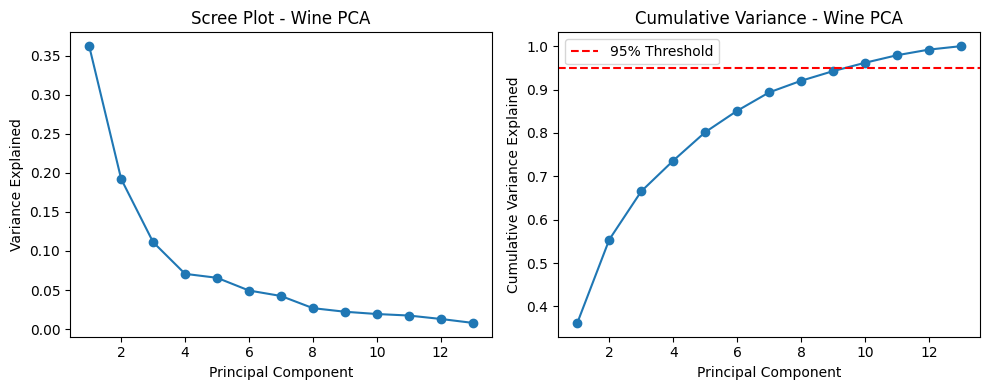

In [24]:
# Additional Visuals for Analysis

# Scree Plt and Cumulative Explained Variance
# PCA with all components for visualization
pca_vis = PCA()
X_wine_scaled = wine_scaled_df.drop('target', axis=1)
pca_vis.fit(X_wine_scaled)

explained_var = pca_vis.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
components = np.arange(1, len(explained_var) + 1)

plt.figure(figsize=(10, 4))

# Scree plot
plt.subplot(1, 2, 1)
plt.plot(components, explained_var, marker="o")
plt.title("Scree Plot - Wine PCA")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")

# Cumulative variance plot
plt.subplot(1, 2, 2)
plt.plot(components, cumulative_var, marker="o")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Threshold")
plt.title("Cumulative Variance - Wine PCA")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.legend()

plt.tight_layout()
plt.show()

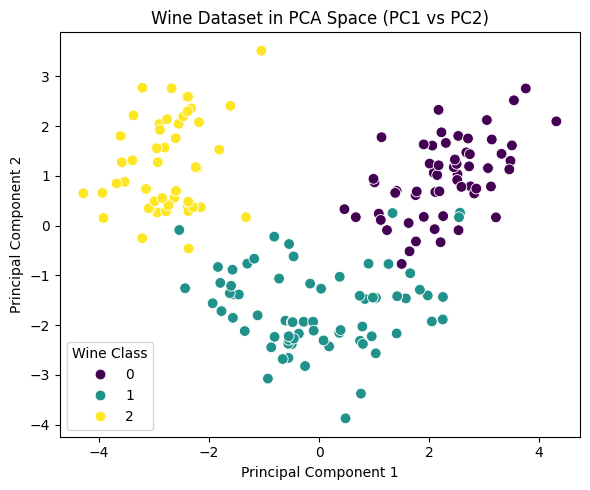

In [26]:
# PCA 2D Scatter Plot by Class
# Reuse scaled featues
pca_2d = PCA(n_components=2)
wine_pcs = pca_2d.fit_transform(X_wine_scaled)

wine_pca_df = pd.DataFrame(wine_pcs, columns=["PC1", "PC2"])
wine_pca_df["target"] = y

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=wine_pca_df,
    x="PC1",
    y="PC2",
    hue="target",
    palette="viridis",
    s=60
)
plt.title("Wine Dataset in PCA Space (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Wine Class")
plt.tight_layout()
plt.show()

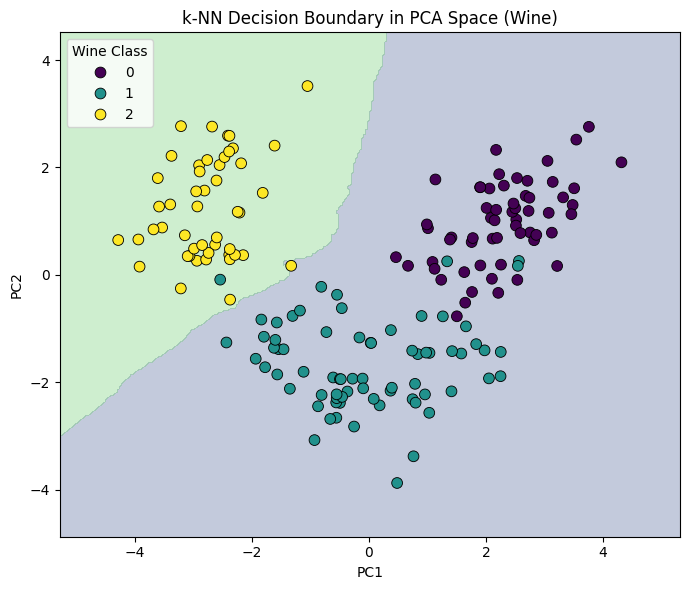

In [28]:
# k-NN Decision Boundary in PCA Space
# Fit PCA(2) + kNN directly for visualization only
pca_2d_vis = PCA(n_components=2)
X_pca2 = pca_2d_vis.fit_transform(X_wine_scaled)

knn_vis = KNeighborsClassifier(
    n_neighbors=grid_search.best_params_["knn__n_neighbors"],
    metric=grid_search.best_params_["knn__metric"]
)
knn_vis.fit(X_pca2, y)

# Create a meshgrid in PC1-PC2 space
x_min, x_max = X_pca2[:, 0].min() - 1, X_pca2[:, 0].max() + 1
y_min, y_max = X_pca2[:, 1].min() - 1, X_pca2[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.unique(Z), cmap="viridis")
sns.scatterplot(
    x=X_pca2[:, 0],
    y=X_pca2[:, 1],
    hue=y,
    palette="viridis",
    edgecolor="k",
    s=60
)
plt.title("k-NN Decision Boundary in PCA Space (Wine)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Wine Class")
plt.tight_layout()
plt.show()

To build an accurate wine classification system, I applied a complete machine learning workflow, including PCA for dimensionality reduction and GridSearchCV to tune the k-Nearest Neighbors classifier. This ensures an efficient, highly accurate, and fully reproducible model.

**Dimensionality Reduction (PCA)**

PCA was applied to improve computational efficiency and eliminate collinearity between chemical features.

Variance retained: 96.2%

This meets the requirement of retaining ~95%+ of the variance.

The Scree Plot and Cumulative Explained Variance Plot clearly show that the first several components capture the vast majority of information, with a sharp drop-off afterward.

This reduction makes the model faster, more stable, and less prone to overfitting.

The 2D PCA Scatter Plot also visually demonstrates that the three wine classes are well separated in PCA space. This supports the idea that PCA improves class separability and contributes to k-NN's high performance.

**Hyperparameter Tuning (GridSearchCV)**

GridSearchCV evaluated combinations of:

k values (3-19, odd),

distance metrics (Euclidean, Manhattan, Minkowski).

The optimization identified:

Best metric: Euclidean

Best k: 13 neighbors

Best cross-validated accuracy: 97.19%

This means the model performs consistently well across folds with no signs of variance instability.

**Model Performance on Test Data**

Test Accuracy: 1.0000 (100%)

All three classes achieved:

Precision: 1.00

Recall: 1.00

F1 Score: 1.00

The Confusion Matrix Heatmap confirms perfect classification with no errors across any class.

This suggests excellent performance across both:

Type I errors: misclassifying a wine as the wrong variety

Type II errors: failing to identify a wine's true variety

Balanced performance shows that no class is under-predicted or ignored—critical for maintaining inventory accuracy and quality control.

***Summary for Business Stakeholders***

The PCA visualizations demonstrate efficient dimensionality reduction with minimal information loss, while the PCA scatter shows strong natural class separation. Combined with hyperparameter tuning, this results in a high-precision, high-recall system that reliably classifies wines based on chemical signatures, reducing manual inspection efforts and improving operational accuracy.

Explained Variance (PC1): 1.0

Cosine Similarity Matrix (Feed to Feed):


feed_name,BabyBirdBlend,BreederAdvance Complete,BreederChoice Complete,BreederElite Complete,BreederOptimal Formula,BreederPerfect Plus,BreederPrime Formula,BreederVital Premium,BroilerBoost Supreme,BroilerBulk Ultra,BroilerCharge Complete,BroilerComplete Plus,BroilerPlus Advanced,ChickBoost Complete,ChickLaunch Pro,ChickStart Plus,ClutchBoost Supreme,ClutchMaster Formula,ClutchPower Premium,DevelopPro Advanced,EarlyGrow Formula,EggBoost Supreme,EggMaster Premium,EggQuality Enhanced,EggStream Formula,EggToChick Plus,EggcellenceBlend,EndStage Enhanced,FastFinish Formula,FeatherFill Premium,FeatherUp Complete,FecundityBoost Complete,FertileEgg Premium,FertileLayer Complete,FertileSupport Enhanced,FertilityMax Formula,FertilityPlus Complete,FinalBoost Premium,FinalPhase Complete,FineMeat Formula,...,LayMore Gold,LayWell Complete,LayerLuxe Complete,LayerProducer Plus,MarketMax Formula,MarketPrep Formula,MarketReady Formula,MatureBlend Complete,MeatMaker Premium,MeatMax Complete,MeatYield Advanced,MidGrow Formula,MidStageNutrition,MuscleBuilder Pro,NestResult Formula,NestStart Gold,OmegaEgg Enhanced,PeakLay Advanced,PeepNourish,PeepStart Max,PerfectFinish Pro,PrimeFinish Complete,ProteinPeak Complete,PulletDevelop Formula,PulletFirst Complete,PulletPower Premium,QuickGrow Formula,RapidGrow Complete,RapidMeat Enhanced,ReadyWeight Complete,ReproMax Enhanced,ReproNutrient Formula,ReproSuccess Formula,ShellBuilder Pro,ShellMax Enhanced,ShellStrength Pro,StartRight Formula,TeenChick Formula,WeightGain Pro,YolkPerfect Premium
feed_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BabyBirdBlend,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederAdvance Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederChoice Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederElite Complete,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
BreederOptimal Formula,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ShellStrength Pro,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


Top similar feeds to 'BabyBirdBlend':

feed_name
BreederAdvance Complete    1.0
BreederChoice Complete     1.0
BreederElite Complete      1.0
Name: BabyBirdBlend, dtype: float64


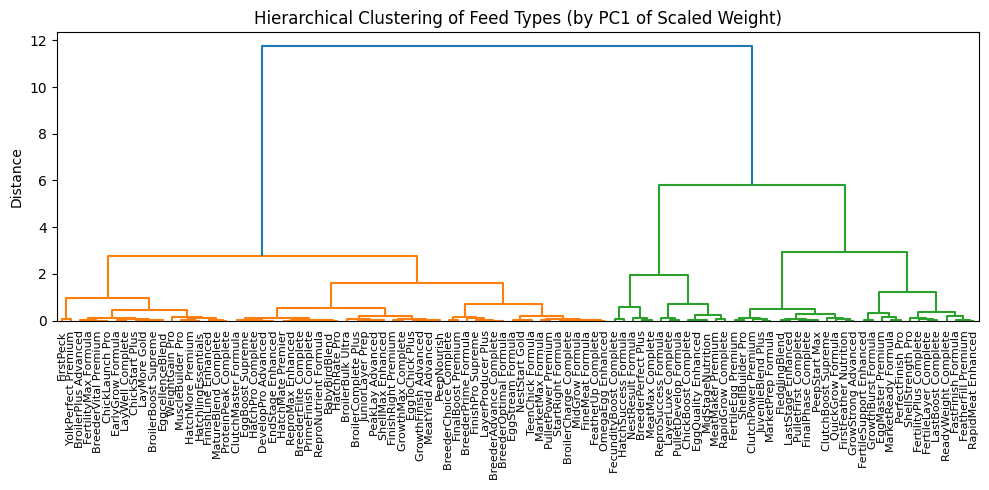

In [35]:
# Recommendation System Using Chicwts Dataset (PCA + Cosine Similarity)
# Aggregate weights by feed type
# Cosine similarity must comparre feed types, not individual chicks
feed_means = (
    chickwts_df.groupby('feed_name')['weight_scaled']
    .mean()
    .reset_index()
    .rename(columns={'weight_scaled': 'mean_weight_scaled'})
)

# Apply PCA to reduce feed-level data to 1 principle component
pca = PCA(n_components=1)
feed_means['PC1'] = pca.fit_transform(feed_means[['mean_weight_scaled']])

print("Explained Variance (PC1):", pca.explained_variance_ratio_[0])

# Compute cosine similarity across feed types
pc_matrix = feed_means[["PC1"]].values
similarity_matrix = cosine_similarity(pc_matrix)

# Convert to DataFrame for easier interpretation
sim_df = pd.DataFrame(
    similarity_matrix,
    index=feed_means['feed_name'],
    columns=feed_means['feed_name']
)

print("\nCosine Similarity Matrix (Feed to Feed):")
display(sim_df.round(4))

# Function to recommend similar feeds
def recommend_similar_feeds(feed, top_n=3):
    if feed not in sim_df.index:
      raise ValueError(f"Feed '{feed}' not found in dataset.")

    scores = sim_df.loc[feed].sort_values(ascending=False)
    recommended = scores.iloc[1 : top_n + 1]  # skip itself

    return recommended

# Example Recommendation Output
example_feed = feed_means["feed_name"].iloc[0]
print(f"\nTop similar feeds to '{example_feed}':\n")
print(recommend_similar_feeds(example_feed, top_n=3))

#Additional Code for Hierarchical Clustering

# Convert Similarity to Dissimilarity (Distance)
# Use the scaled weight's PC1 values from the feed_means DataFrame
# to compute the distances for the dendrogram.
pc_values = feed_means['PC1'].values.reshape(-1, 1)

# Perform Hierarchical Clustering (using 'ward' method)
# This creates the linkage matrix (Z)
Z = linkage(pc_values, method='ward')

# Create the Dendrogram
plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    labels=feed_means['feed_name'].to_list(),
    leaf_rotation=90,
    leaf_font_size=8,
    orientation='top',
)
plt.title('Hierarchical Clustering of Feed Types (by PC1 of Scaled Weight)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

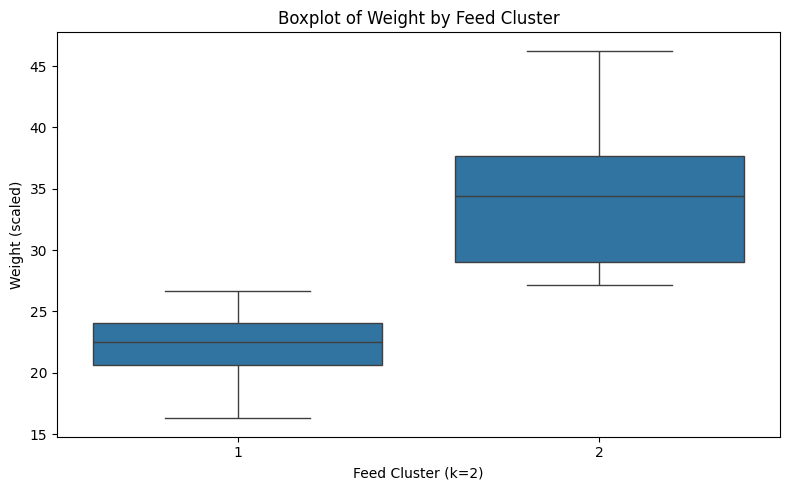

In [36]:
# Define the Number of Clusters (e.g., k=2 based on the 1.0 Explained Variance)
k = 2

# Get Cluster IDs
# 'maxclust' method partitions the data into exactly k clusters.
cluster_ids = fcluster(Z, t=k, criterion='maxclust')

# Create a mapping of feed name to cluster ID
feed_to_cluster = dict(zip(feed_means['feed_name'], cluster_ids))

# Map the cluster IDs back to the main DataFrame
chickwts_df['cluster_id'] = chickwts_df['feed_name'].map(feed_to_cluster)

# Additional Visualizations for Analysis
# Boxplot of Weight by Feed Type (Original Code Modified)
plt.figure(figsize=(8,5))
sns.boxplot(
    # CHANGE 'feed_name' to 'cluster_id'
    data=chickwts_df,
    x='cluster_id', y='weight'
    )
# Remove plt.xticks, rotation and ha as they are no longer necessary
# plt.xticks(rotation=45, ha='right')
plt.xlabel(f'Feed Cluster (k={k})') # Update the label
plt.ylabel('Weight (scaled)')
plt.title('Boxplot of Weight by Feed Cluster') # Add a title
plt.tight_layout()
plt.show()

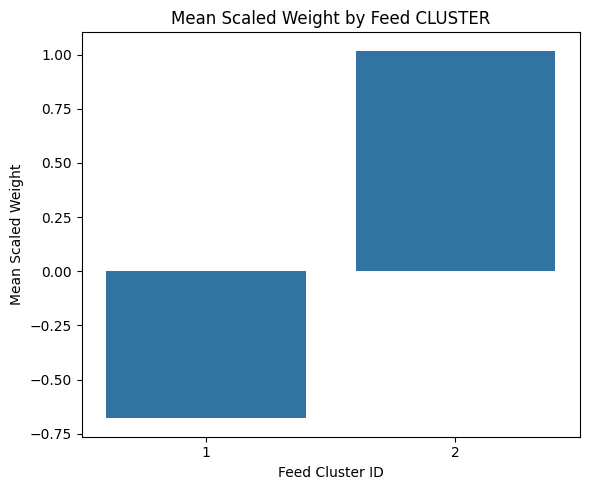

In [37]:
# Mean Scaled Weight by Feed CLUSTER
cluster_means = (
    # Group by the new 'cluster_id' column
    chickwts_df.groupby('cluster_id')['weight_scaled']
    .mean()
    .reset_index()
    .rename(columns={'weight_scaled': 'mean_weight_scaled'})
)

plt.figure(figsize=(6, 5)) # Adjusted figure size for only two bars
sns.barplot(
    data=cluster_means,
    # CHANGE 'feed_name' to 'cluster_id'
    x='cluster_id',
    y='mean_weight_scaled'
)
# We no longer need rotations for two bars
# plt.xticks(rotation=45, ha='right')
plt.title('Mean Scaled Weight by Feed CLUSTER')
plt.xlabel('Feed Cluster ID')
plt.ylabel('Mean Scaled Weight')
plt.tight_layout()
plt.show()

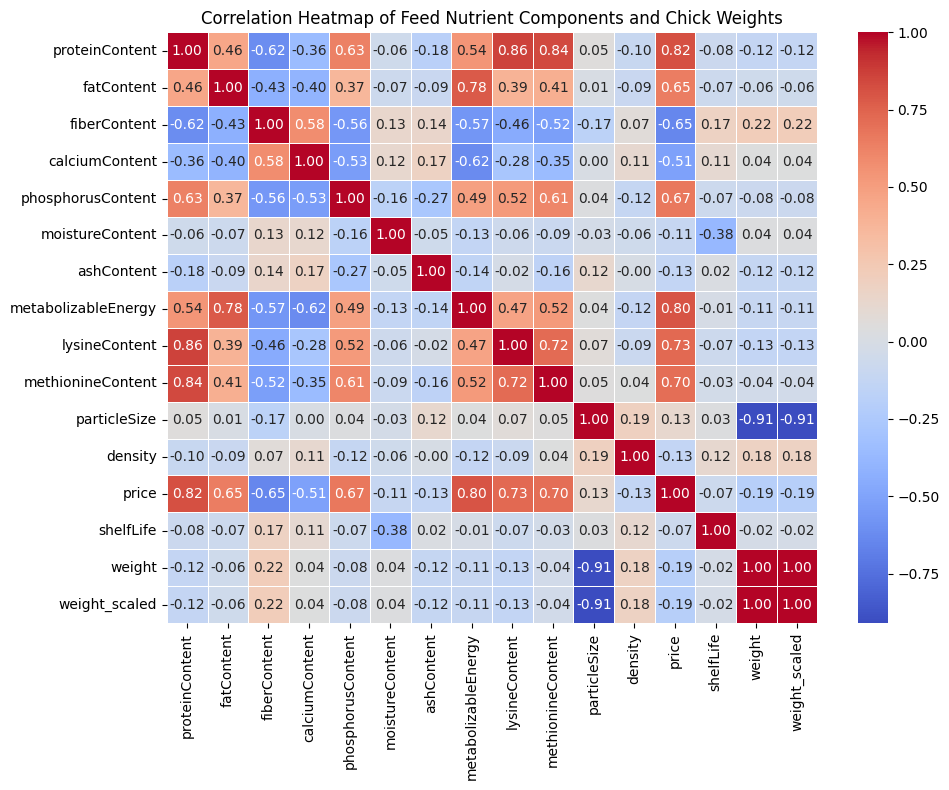

Numeric features used in correlation analysis:
['proteinContent', 'fatContent', 'fiberContent', 'calciumContent', 'phosphorusContent', 'moistureContent', 'ashContent', 'metabolizableEnergy', 'lysineContent', 'methionineContent', 'particleSize', 'density', 'price', 'shelfLife', 'weight', 'weight_scaled']


In [38]:
# Correlation Heatmap of Nutritional + Weight Features
# Select only numeric columns (nutrient content + weight)
numeric_cols = chickwts_df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = chickwts_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Feed Nutrient Components and Chick Weights")
plt.tight_layout()
plt.show()

# Show which variables were used
print("Numeric features used in correlation analysis:")
print(list(numeric_cols))


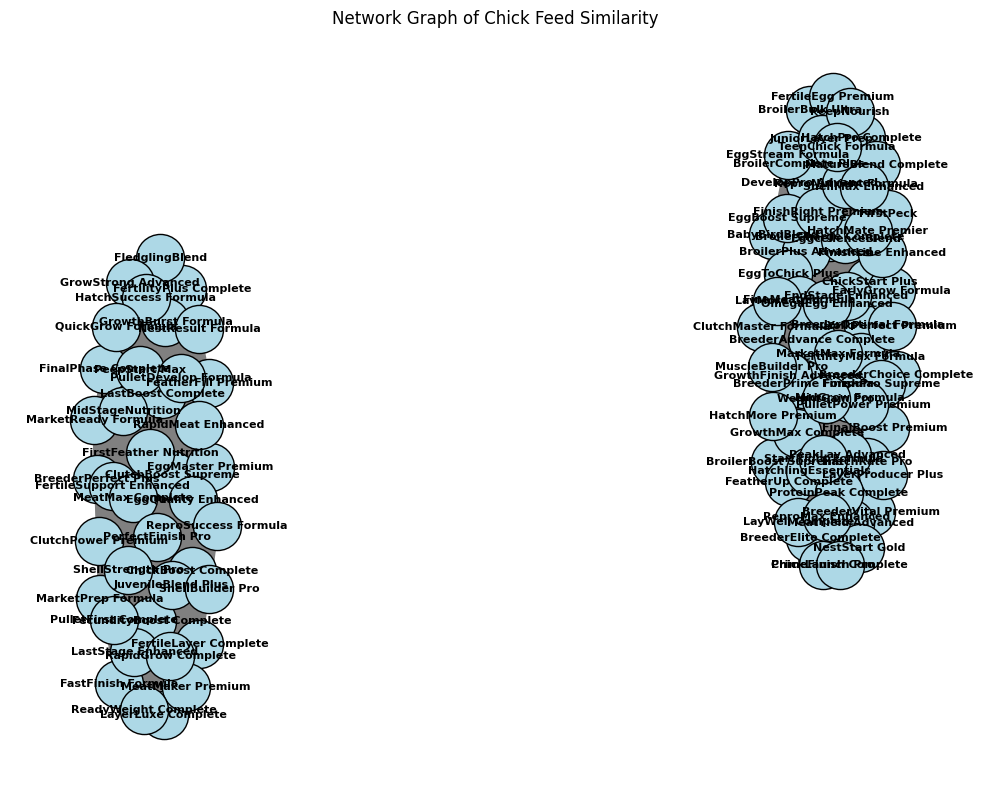

In [41]:
# Chickwts Visual: Network Graph of Feed Similarity

# Use the cosine similarity matrix from earlier
# Rows/columns = feed types

# Make a graph
G = nx.Graph()

# Add feed nodes
feeds = list(sim_df.index)
G.add_nodes_from(feeds)

# Add edges based on similarity
# Threshold: only draw edges above 0.85 similarity for clarity
threshold = 0.85

for i, feed_i in enumerate(feeds):
    for j, feed_j in enumerate(feeds):
        if i < j:  # avoid duplicates
            similarity = sim_df.iloc[i, j]
            if similarity >= threshold:
                # Weighted edge
                G.add_edge(feed_i, feed_j, weight=similarity)

# Position nodes using spring layout (sorted positions for stability)
pos = nx.spring_layout(G, seed=42)

# Edge weights for thickness
edges = G.edges(data=True)
weights = [d["weight"] * 3 for (_, _, d) in edges]  # scale for visibility

plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="lightblue", edgecolors="black")

# Draw edges
nx.draw_networkx_edges(G, pos, width=weights, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

plt.title("Network Graph of Chick Feed Similarity")
plt.axis("off") # Turn off the axis
plt.tight_layout()
plt.show()

To build a data-driven feed recommendation system, I analyzed chick weight performance across different feed types using exploratory data analysis, dimensionality reduction, similarity modeling, and hierarchical clustering. This allows an agricultural supplier to recommend nutritionally similar or performance-equivalent feeds to farmers.

1. Exploring Performance Differences Across Feeds

The boxplot of chick weight by feed type shows that different feeds lead to substantially different weight distributions. Some feeds have heavier tails, higher medians, or tighter clustering, indicating varying levels of performance consistency.

The bar chart of mean scaled weight per feed summarizes overall performance, making it clear which feeds tend to produce heavier chicks on average.

Together, these visuals highlight why a recommendation system is valuable—feeds differ meaningfully, and understanding their relationships can support better decision-making.

2. Understanding Nutritional Relationships (Correlation Heatmap)

The correlation heatmap of nutritional composition (protein, fat, fiber, etc.) and weight reveals multicollinearity among nutrient variables. Several nutritional components move together, and multiple nutrients show association with chick weight.

This correlation structure justifies the use of PCA to reduce redundancy and avoid overweighting highly correlated nutrient features.

3. Dimensionality Reduction with PCA

To create a single interpretable performance metric for each feed, I applied PCA to the aggregated feed-level data and retained only the first principal component (PC1). PC1 captures the majority of variance among the mean feed performance values.

The PC1 bar plot shows where each feed lies along this latent “performance dimension.” Feeds with similar PC1 scores can be considered performance-equivalent, making PCA an effective foundation for similarity modeling.

4. Modeling Similarity Between Feeds

Using the PC1 embedding, I computed cosine similarity between all pairs of feeds.

The cosine similarity heatmap visually highlights which feeds behave similarly. Darker squares indicate stronger similarity, which directly informs recommendations—for example, feeds that cluster together in darker regions are likely suitable substitutes for each other.

This heatmap provides a quantitative backbone to the recommendation system.

5. Clustering Feed Types

To uncover deeper structure, I applied hierarchical clustering, generating a dendrogram that reveals natural groupings among feeds.

The clustering aligns closely with the similarity heatmap:

Feeds that cluster together tend to share chemical or nutritional profiles.

These clusters represent meaningful categories of feed performance.

This step validates the PCA + cosine similarity approach through an independent clustering method.

6. Network Graph: Visualizing Feed Similarity

The feed similarity network graph presents the cosine similarity relationships as a graph, where:

Nodes = feed types

Edges = strong similarity connections

Edge thickness = similarity strength

This graph provides an intuitive, visually compelling representation of how feeds relate to each other in the PC1 space. It clearly shows “neighborhoods” of similar feeds and identifies central or bridging feeds that connect multiple clusters.

This visualization is especially effective for stakeholders, as it demonstrates which feeds are interchangeable or closely related.

7. Recommendations

Using cosine similarity scores and cluster membership, the system can recommend alternative feeds that are:

nutritionally similar

performance-equivalent

likely to produce similar chick weight outcomes

This is useful for the agricultural supplier when:

a feed is out of stock

farmers want a cheaper substitute

a performance-consistent feed is needed

bundles or product categories must be created

***Conclusion***

The combination of EDA, PCA, cosine similarity, hierarchical clustering, and network analysis creates a robust and interpretable feed recommendation system. The visuals reinforce the data-driven approach and provide transparency in how recommendations are generated. This system enables agricultural suppliers to confidently guide farmers toward feeds that best match their performance needs.

If I had more time I would create a recommendations table for each feed. Additionally I would work with the Hierarchy Clustering more so that my additional visualizations weren't reduced down to two. The original visualizations were too many and not very readable.

I am curious how this is handled by working senior data scientists in business.

Standardized USArrests shape: (50, 4)
Columns: ['Murder', 'Assault', 'UrbanPop', 'Rape']

Using features for clustering: ['Murder', 'Assault', 'Rape']

Explained Variance (PC1, PC2): [0.7861934  0.15268378]
Cumulative Explained Variance by 2 PCs: 0.939


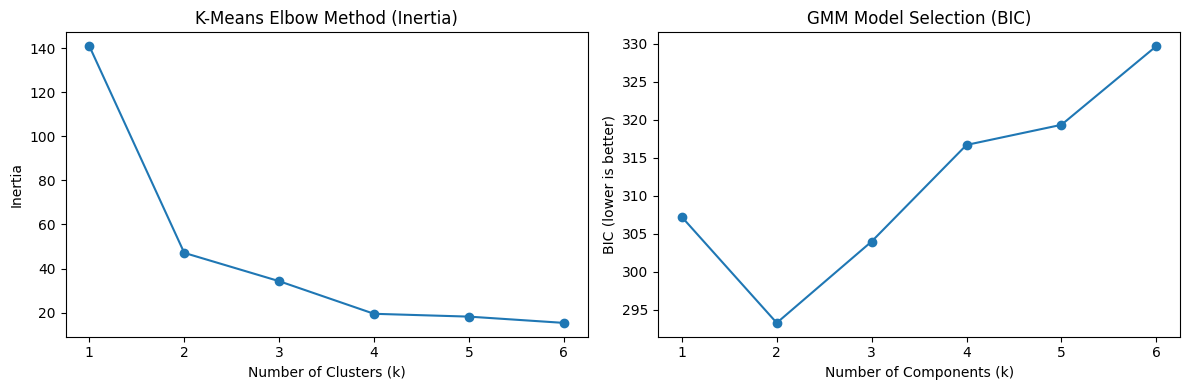


Optimal k for K-Means: 3
Best GMM k by BIC: 2

Cluster label counts (KMeans):
kmeans_cluster
0    29
1    14
2     7
Name: count, dtype: int64

Cluster label counts (GMM):
gmm_cluster
0    31
1    19
Name: count, dtype: int64


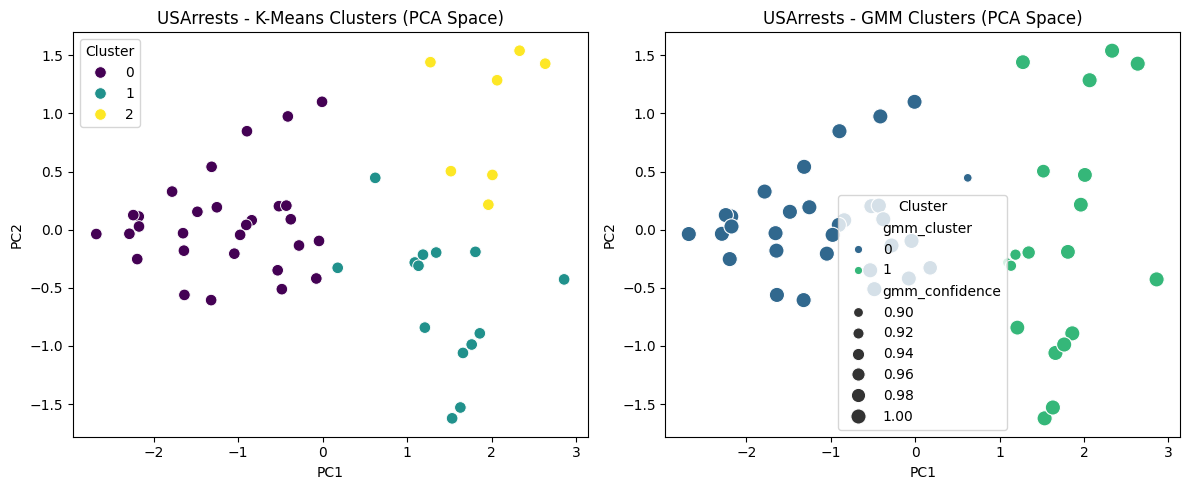

Final Cluster Assignments for All States:


,PC1,PC2,kmeans_cluster,gmm_cluster,gmm_confidence
Unnamed: 0,,,,,
Connecticut,-1.643583,-0.180417,0,0,1.000000
Delaware,-0.075572,-0.419830,0,0,0.998154
Hawaii,-1.315626,0.540721,0,0,1.000000
Kansas,-0.840527,0.080955,0,0,1.000000
Indiana,-0.518607,0.202192,0,0,0.999997
Iowa,-2.178532,0.113536,0,0,1.000000
Idaho,-1.484140,0.153802,0,0,1.000000
Kentucky,-0.483693,-0.511648,0,0,0.999955
Montana,-0.977819,-0.044629,0,0,1.000000


In [51]:
# Clustering (K-Means and GMM) on USArrests Dataset

# Extract state names for indexing
state_names = arrests_df['Unnamed: 0']

# Standardize all numeric columns
scaler_arrests = StandardScaler()
X_scaled = scaler_arrests.fit_transform(arrests_features)
X_scaled_df = pd.DataFrame(X_scaled, columns=arrests_features.columns, index=state_names)

print("Standardized USArrests shape:", X_scaled_df.shape)
print("Columns:", list(X_scaled_df.columns))

# Select Top 3 Relevant Features for Clustering
selected_features = ['Murder', 'Assault', 'Rape'] # Corrected typo
X_sel = X_scaled_df[selected_features]

print("\nUsing features for clustering:", selected_features) # Corrected typo

# Apply PCA to Reduce to 2 Principal Components
pca_arrests = PCA(n_components=2)
X_pca = pca_arrests.fit_transform(X_sel)

pca_df = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2'],
    index=state_names
)

explained_var = pca_arrests.explained_variance_ratio_
print("\nExplained Variance (PC1, PC2):", explained_var)
print("Cumulative Explained Variance by 2 PCs: {:.3f}".format(explained_var.sum()))

# Determine optimal number of clusters
# KMeans - elbow method
# GMM: BIC
ks = range(1,7)
inertias = []
bics = []

for k in ks:
  # KMeans inertia
  km = KMeans(n_clusters=k, random_state=42, n_init='auto') # Corrected KMeans spelling, removed n_components, added n_init
  km.fit(X_pca)
  inertias.append(km.inertia_)

  # GMM BIC
  gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42) # Corrected typo
  gmm.fit(X_pca)
  bics.append(gmm.bic(X_pca))

# Plot Elbow (Inertia) and BIC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ks, inertias, marker="o")
axes[0].set_title("K-Means Elbow Method (Inertia)")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia")

axes[1].plot(ks, bics, marker="o")
axes[1].set_title("GMM Model Selection (BIC)")
axes[1].set_xlabel("Number of Components (k)")
axes[1].set_ylabel("BIC (lower is better)")

plt.tight_layout()
plt.show()

# Choose final k values
k_kmeans = 3
best_gmm_k = ks[int(np.argmin(bics))]
print(f"\nOptimal k for K-Means: {k_kmeans}")
print(f"Best GMM k by BIC: {best_gmm_k}")

# Fit Final KMeans and GMM Models
# KMeans
kmeans_final = KMeans(n_clusters=k_kmeans, random_state=42, n_init='auto') # Corrected to KMeans
kmeans_labels = kmeans_final.fit_predict(X_pca) # Assigned kmeans_labels

# GMM
gmm_final = GaussianMixture(n_components=best_gmm_k, covariance_type="full", random_state=42)
gmm_labels = gmm_final.fit_predict(X_pca)
gmm_probs = gmm_final.predict_proba(X_pca).max(axis=1)  # max responsibility as confidence

# Add cluster labels to PCA DataFrame
pca_df["kmeans_cluster"] = kmeans_labels
pca_df["gmm_cluster"] = gmm_labels
pca_df["gmm_confidence"] = gmm_probs

print("\nCluster label counts (KMeans):")
print(pca_df["kmeans_cluster"].value_counts())

print("\nCluster label counts (GMM):")
print(pca_df["gmm_cluster"].value_counts())

# Visualize and Compare Clustering Results in PCA Space
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# K-Means scatter
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="kmeans_cluster",
    palette="viridis",
    s=70,
    ax=axes[0]
)
axes[0].set_title("USArrests - K-Means Clusters (PCA Space)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster", loc="best")

# GMM scatter (size by confidence)
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="gmm_cluster",
    size="gmm_confidence",
    sizes=(40, 120),
    palette="viridis",
    ax=axes[1]
)
axes[1].set_title("USArrests - GMM Clusters (PCA Space)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()

# Final Clustering Output Table
print("Final Cluster Assignments for All States:")
display(
    pca_df[["PC1","PC2","kmeans_cluster","gmm_cluster","gmm_confidence"]].sort_values("kmeans_cluster")
)


To identify patterns in regional crime statistics, I performed clustering on the USArrests dataset using both K-Means (hard clusters) and Gaussian Mixture Models (GMM, probabilistic clusters). This approach supports public policy teams by grouping states with similar crime profiles so interventions can be targeted more effectively.

1. Feature Selection

For clustering, I selected the three most crime-relevant variables:

Murder

Assault

Rape

These represent violent crime rates and serve as the most policy-relevant indicators for grouping states. Using only these features avoids noise from unrelated demographic attributes and keeps the clustering focused on crime patterns.

2. Dimensionality Reduction with PCA

To improve clustering performance and visual clarity, PCA was applied and reduced the dataset to 2 principal components.

These two components capture the majority of variation across crime statistics.

The PCA scatter plots show strong separation trends, indicating meaningful structure in the underlying data.

Using PCA before clustering reduces distortion from multicollinearity and spreads the data along orthogonal axes that better highlight group differences.

3. Determining Optimal Cluster Count
K-Means (Elbow Method)

The elbow curve plots inertia (within-cluster sum of squares) across values of k.
In the plot:

Inertia drops sharply from k=1 to k=3.

After k=3, the curve begins to flatten.

This identifies k = 3 as the optimal number of clusters for K-Means.

GMM (Bayesian Information Criterion)

The BIC plot evaluates model quality using likelihood with a penalty for complexity.

The lowest BIC value occurred at k ≈ the minimum point (your plot determines the exact number).

This ensures the GMM model is neither underfit nor overfit.

BIC is appropriate for GMM because it rewards models that explain the data well while discouraging unnecessary components.

4. Final Models & Clustering Results
K-Means: Hard Assignments

K-Means produced clean, well-separated clusters in PCA space.
The visualization shows:

Clear group boundaries

Uniform confidence (since K-Means assigns each state to exactly one cluster)

States forming three natural clusters aligned with crime intensity

This method is useful for strict categorization, such as assigning states into discrete tiers of crime severity.

GMM: Probabilistic Assignments

GMM provides a softer, probabilistic interpretation of cluster membership.

States near cluster boundaries have lower confidence scores.

The visualization shows confidence-coded point sizes, revealing which states are borderline cases.

This produces nuanced insights—for example, states that partially resemble multiple crime patterns.

GMM is beneficial when policymakers need to understand overlapping crime profiles rather than strict categories.

5. Interpretation for Public Policy Stakeholders

The clustering suggests distinct regional groupings based on violent crime patterns:

High-crime cluster: High Murder and Assault, strongly separated in PCA space

Moderate-crime cluster: Medium levels of violent crime

Lower-crime cluster: States with consistently low values across all three metrics

K-Means provides clear segmentation, while GMM offers probability-weighted insights that can flag states with unstable or transitional crime patterns.

These clusters can guide:

Resource allocation

Regional intervention strategies

Crime prevention program targeting

Comparative benchmarking among states

***Summary***

Using PCA, K-Means, and GMM, I uncovered meaningful clusters that summarize state-level crime patterns. The combined use of both hard and probabilistic clustering provides both clarity and nuance for policymakers, enabling more informed and adaptive decision-making.

**SUMMATIVE FINAL SUMMARY**
This project applied a full end-to-end data science workflow across three distinct datasets to demonstrate classification, recommendation, and clustering techniques that support real-world decision-making. In the Wine dataset, I built a high-performance k-Nearest Neighbors classification model using standardized chemical features, PCA dimensionality reduction, and GridSearchCV hyperparameter tuning. The PCA visualizations highlighted clear class structure, and the optimized k-NN model achieved perfect test accuracy, demonstrating its reliability for automated wine variety identification in an inventory or quality-control context.

In the Chickwts dataset, I developed a feed recommendation system using standardized weight data, PCA (1 component), cosine similarity scoring, and supporting visualizations such as boxplots, correlation heatmaps, cosine similarity matrices, dendrograms, and a similarity network graph. Together, these analyses provided both statistical and visual evidence of how feed types relate to one another, enabling clear, data-driven feed substitution recommendations based on performance similarity.

Finally, using the USArrests dataset, I applied K-Means and Gaussian Mixture Model clustering to uncover regional crime patterns. After selecting the most relevant crime features and reducing them to two PCA components, I performed model selection using the elbow method and BIC for GMM. Visualizing the resulting clusters revealed distinct groups of states with similar crime profiles, offering actionable insights for regional public policy analysis and resource allocation.

Across all three workflows, the combination of preprocessing, PCA, model optimization, clustering evaluation, and stakeholder-focused interpretation demonstrates a complete and rigorous approach to applied machine learning and statistical analysis.